# Final Capstone

Stock market analysis is generally divided into two parts - Fundamental Analysis and Technical Analysis. Fundamental Analysis involves using a company's current business environment and financial performance to analyze its future profitability. However, Technical Analysis involves analyzing stock charts and identifying trends in the stock market using statistical figures. This project will focus on Technical Analysis.

Initially, I planned on obtaining the data from an API service like AlphaVantage. However, this API does not offer the adjusted stock price data, meaning the data would not account for splits or other key events. Thus, it would be unusable for modeling. Therefore, I obtained a dataset from Kaggle which provided five years worth of adjusted stock price data for a selected group of Dow Jones stocks.

https://www.kaggle.com/timoboz/stock-data-dow-jones

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

import glob
filelist = glob.glob("stock-data-dow-jones/*.csv")

from fastai.tabular import add_datepart

pd.plotting.register_matplotlib_converters()

## Data Wrangling

We will start with AAPL as our baseline stock to model, and then select another stock from the dataset which has a high correlation with AAPL.

In [244]:
# Load data
AAPL = pd.read_csv('stock-data-dow-jones/AAPL.csv', sep=',', index_col=0, parse_dates=True)
cols = ['open', 'high', 'low', 'close', 'volume']
AAPL = AAPL[cols].copy()
#AAPL.columns = ['open', 'high', 'low', 'close', 'volume']

df_stocks = pd.DataFrame()

for file in filelist:
    # Exclude DWDP since it was recently added to the DOW
    if 'DWDP.csv' in file:
        continue
    df = pd.read_csv(file)
    df['symbol'] = file.split('/')[-1].split('.')[0]
    df_stocks = df_stocks.append(df)

cols = ['date', 'close', 'volume', 'symbol']
df_stocks = df_stocks[cols].copy()
df_stocks['date'] = pd.to_datetime(df_stocks['date'])

# Create a dataframe of closing prices for each stock
df = df_stocks.pivot(index='date', columns='symbol', values='close')

df.head()

symbol,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2014-02-21,68.9821,82.2720,112.8920,83.4824,18.8421,92.1690,74.6463,153.7179,69.8159,152.3849,...,26.3114,66.3520,74.7163,68.2609,102.5660,53.9535,37.6033,60.9569,63.8826,78.7855
2014-02-24,69.2841,83.3566,114.0449,83.3283,18.8335,93.3714,75.2052,155.6242,69.9326,152.9351,...,26.7547,66.2584,74.4042,70.2955,103.5527,54.6371,36.7760,61.1408,64.0836,79.9545
2014-02-25,68.5631,83.3473,111.5720,82.5491,18.5951,94.0422,74.7208,152.7648,72.7256,152.7517,...,26.6710,66.4797,74.3151,69.6574,103.0193,54.8593,36.8238,61.5360,64.0836,79.8467
2014-02-26,67.9446,83.1804,111.4224,83.2256,18.6718,94.4839,74.5997,152.6428,73.3722,153.4436,...,26.7547,66.2584,74.3953,70.3418,103.2149,54.6177,36.8715,61.1316,65.3329,79.4156
2014-02-27,69.2999,83.6996,113.1385,82.7974,18.6633,94.6311,74.9724,155.0618,73.6147,154.4523,...,26.9554,66.5392,74.7698,70.3048,103.6594,54.6588,37.7863,62.6757,65.1407,79.4571


## Data Exploration

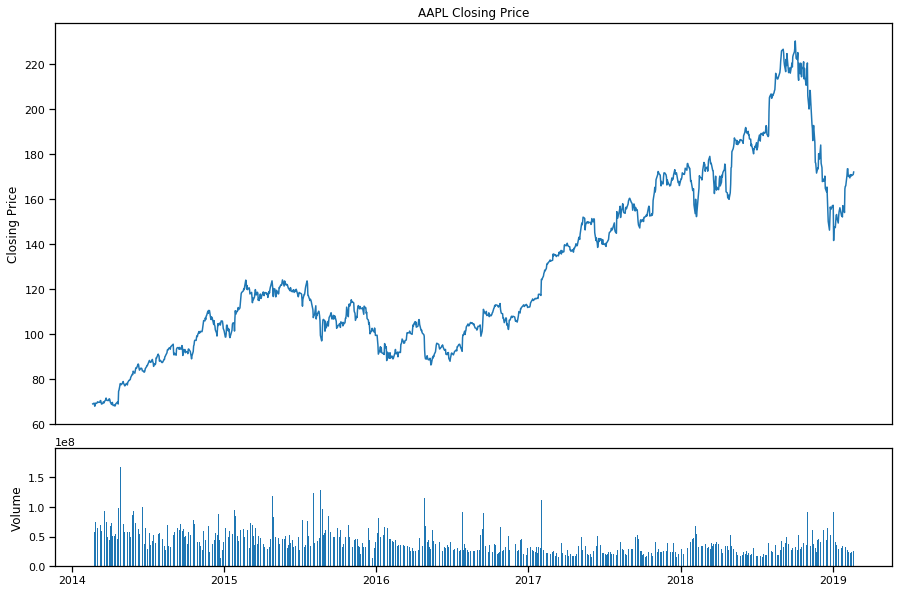

In [303]:
plt.figure(figsize=(15,10))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(AAPL.index, AAPL.close) 
bottom.bar(AAPL.index, AAPL.volume) 
 
# set the labels
top.axes.get_xaxis().set_visible(False)
top.set_title('AAPL Closing Price')
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume');

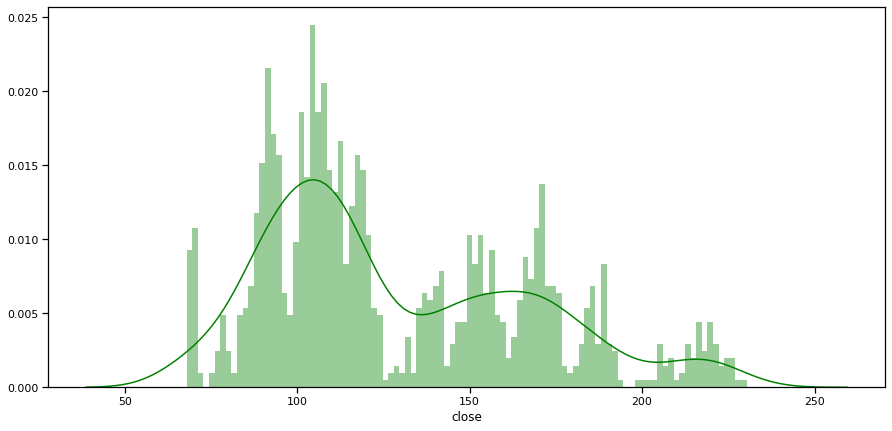

In [246]:
plt.figure(figsize=(15,7))
sns.distplot(AAPL.close.dropna(), bins=100, color='green');

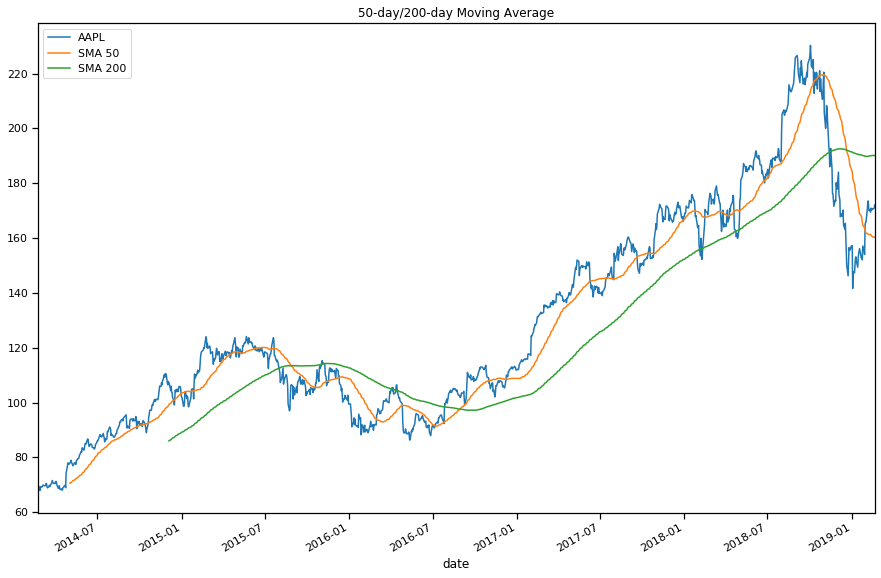

In [310]:
sma50 = AAPL['close'].rolling(50).mean()
sma200 = AAPL['close'].rolling(200).mean()
 
AAPL_sma = pd.DataFrame({'AAPL': AAPL.close, 'SMA 50': sma50, 'SMA 200': sma200})
AAPL_sma.plot(figsize=(15, 10), legend=True, title='50-day/200-day Moving Average');

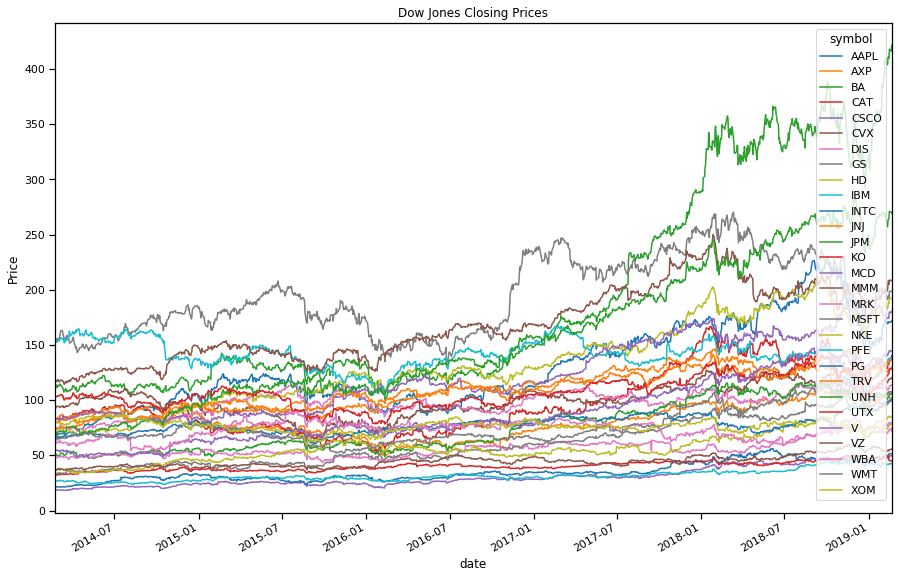

In [312]:
df.plot(figsize=(15,10))
plt.ylabel('Price');
plt.title('Dow Jones Closing Prices');

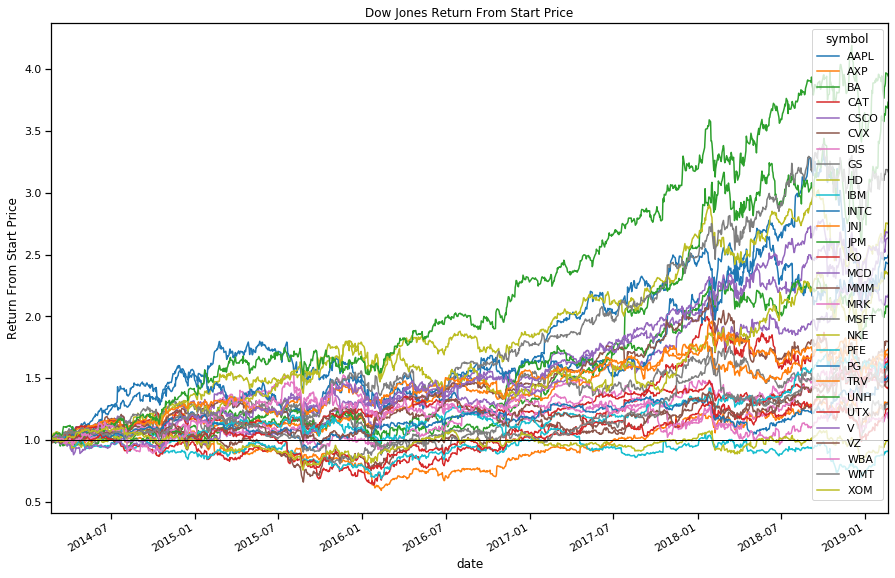

In [311]:
returnfstart = df.apply(lambda x: x / x[0])
returnfstart.plot(figsize=(15,10)).axhline(1, lw=1, color='black')
plt.ylabel('Return From Start Price');
plt.title('Dow Jones Return From Start Price');

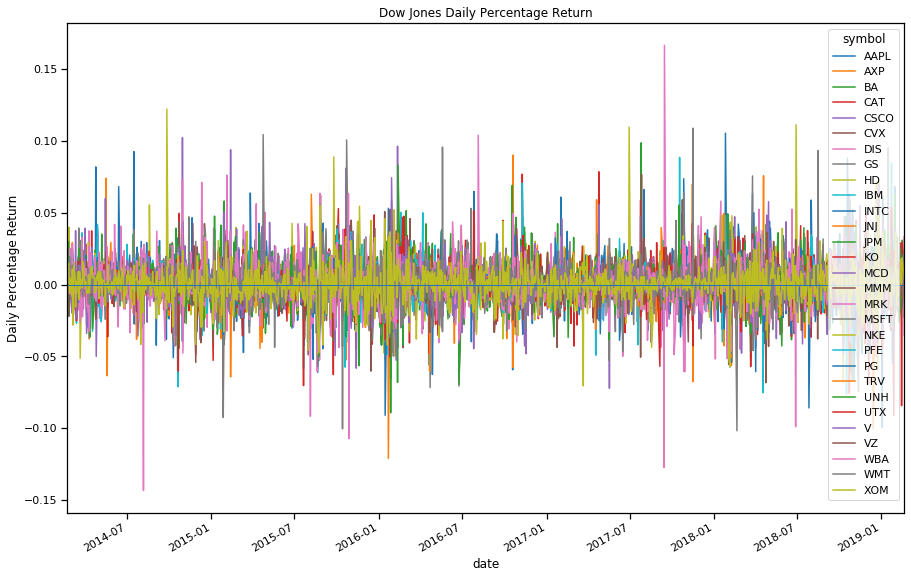

In [306]:
df.pct_change().plot(figsize=(15,10))
plt.axhline(0, lw=1)
#plt.axhline(0, color='black', lw=1)
plt.ylabel('Daily Percentage Return');
plt.title('Dow Jones Daily Percentage Return');

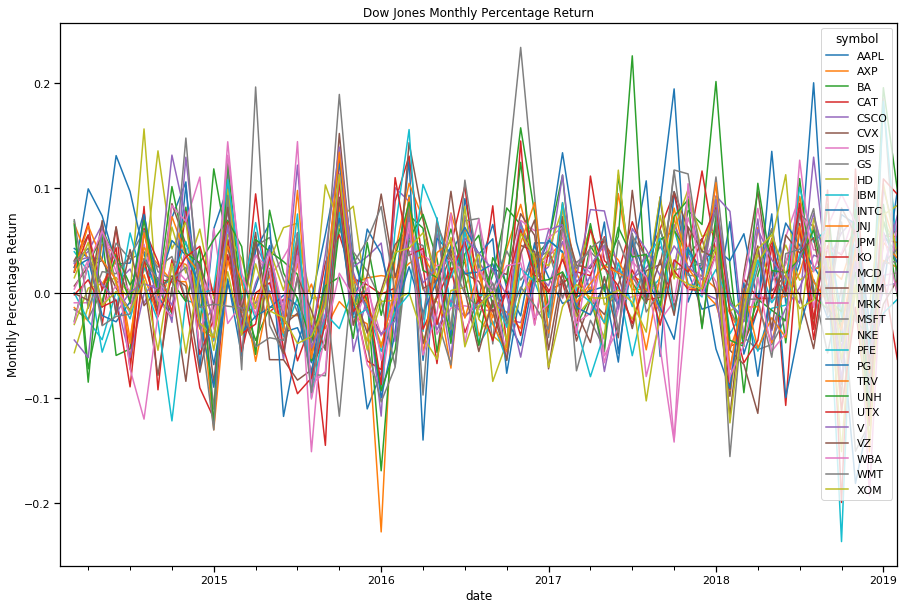

In [307]:
# Resample df to business months, take last observation as value 
monthly = df.resample('BM').apply(lambda x: x[-1])

# Calculate the monthly percentage change
monthly.pct_change().plot(figsize=(15,10))
plt.axhline(0, color='black', lw=1)
plt.ylabel('Monthly Percentage Return');
plt.title('Dow Jones Monthly Percentage Return');

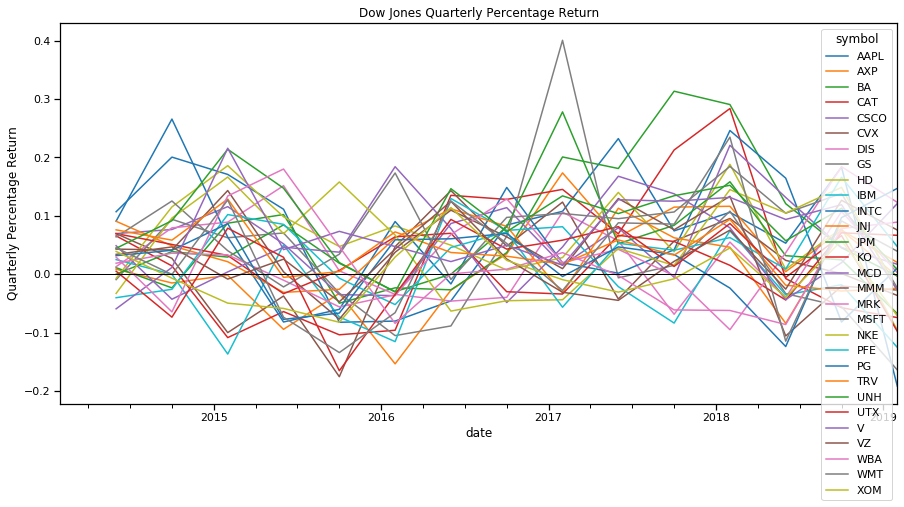

In [308]:
# Resample df to quarters, take the mean as value per quarter
quarterly = df.resample('4M').mean()

# Calculate the quarterly percentage change
quarterly.pct_change().plot(figsize=(15,7))
plt.axhline(0, color='black', lw=1)
plt.ylabel('Quarterly Percentage Return');
plt.title('Dow Jones Quarterly Percentage Return');

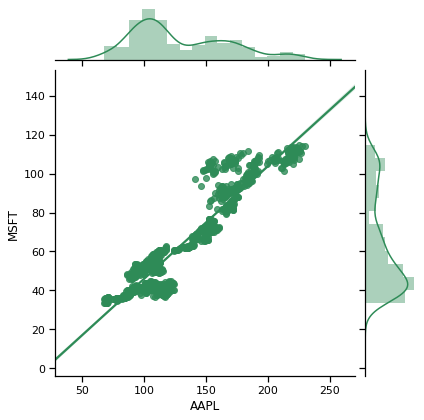

In [257]:
sns.jointplot('AAPL', 'MSFT', df, kind='reg', color='seagreen');

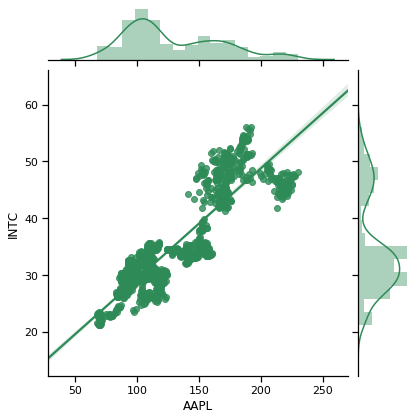

In [258]:
sns.jointplot('AAPL', 'INTC', df, kind='reg', color='seagreen');

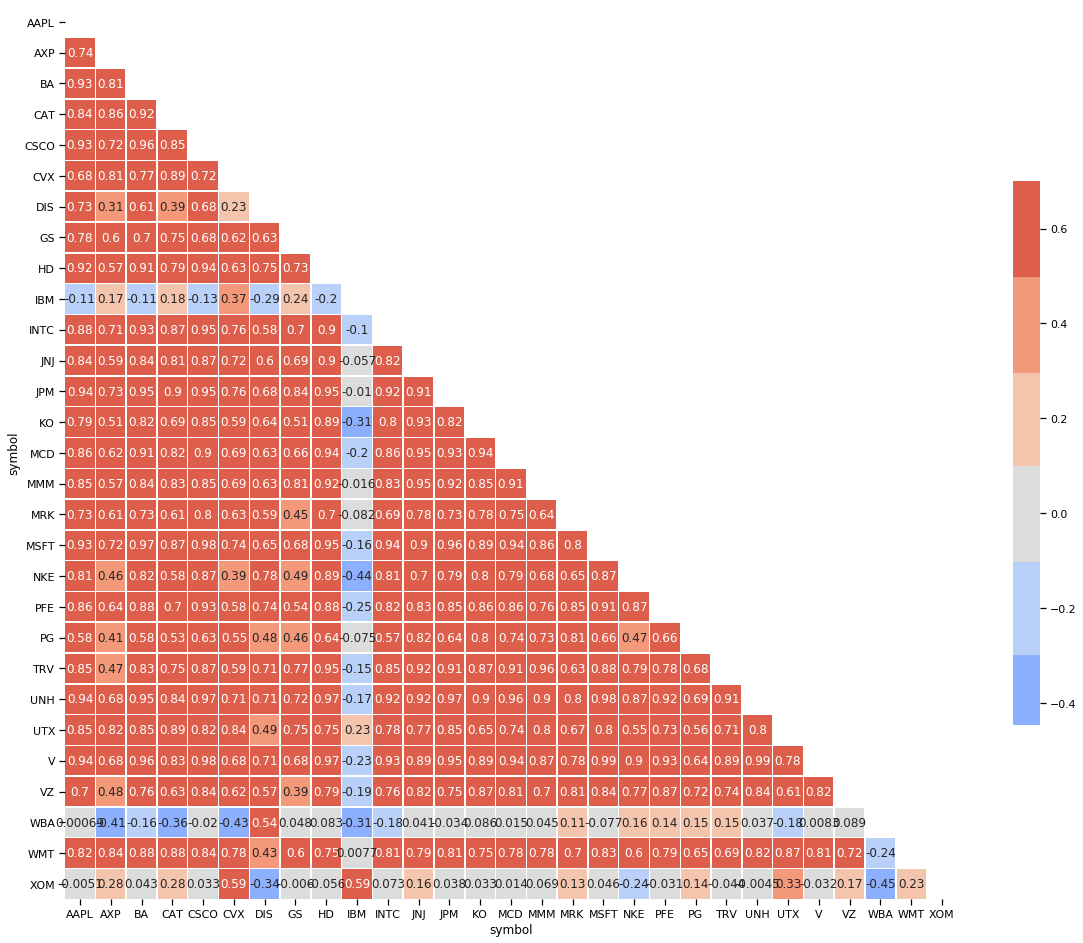

In [259]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = sns.color_palette("coolwarm", 7)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.7, center=0, annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5});

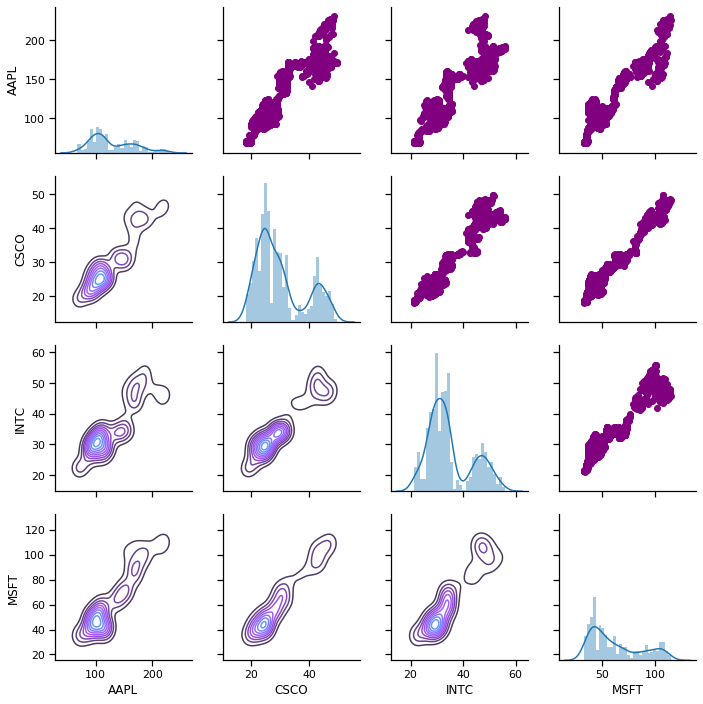

In [260]:
fig = sns.PairGrid(df[['AAPL', 'CSCO', 'INTC', 'MSFT']].dropna())
# define top, bottom and diagonal plots
fig.map_upper(plt.scatter, color='purple')
fig.map_lower(sns.kdeplot, cmap='cool_d')
fig.map_diag(sns.distplot, bins=30);

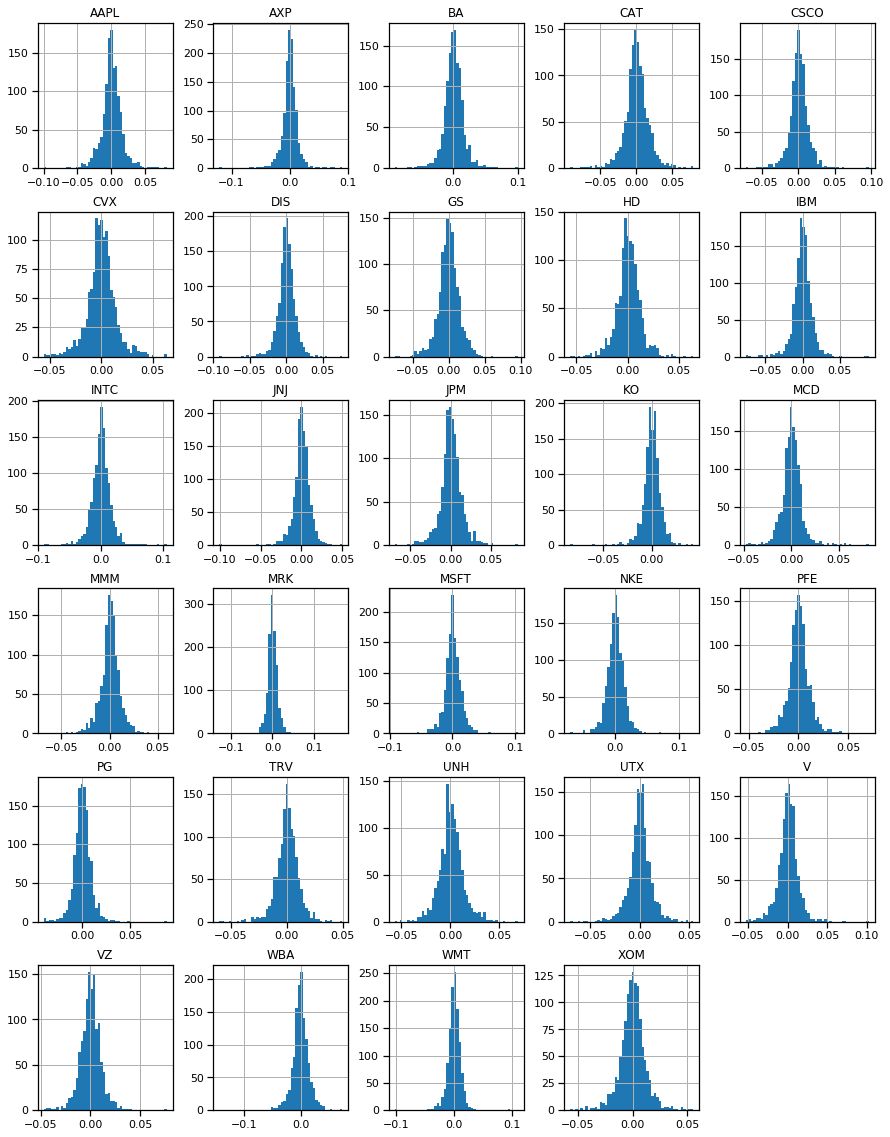

In [261]:
daily_pct_c = df/ df.shift(1) -1
daily_pct_c.hist(bins=50, figsize=(15,20))
plt.show()

In [262]:
display(daily_pct_c.describe())

symbol,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,...,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,0.000846,0.000300,0.001158,0.000548,0.000860,0.000308,0.000404,0.000311,0.000874,0.000003,...,0.000438,0.000364,0.000492,0.001176,0.000246,0.000872,0.000370,0.000255,0.000431,0.000067
std,0.015393,0.013544,0.014810,0.016424,0.013384,0.013876,0.011716,0.014606,0.011772,0.012772,...,0.011157,0.009370,0.010314,0.012928,0.011563,0.013231,0.010616,0.015695,0.012281,0.011809
min,-0.099607,-0.121008,-0.089290,-0.091261,-0.072145,-0.055666,-0.091708,-0.074557,-0.055988,-0.076282,...,-0.052992,-0.040065,-0.060536,-0.056461,-0.070330,-0.052698,-0.046810,-0.143374,-0.101832,-0.056903
25%,-0.005993,-0.005374,-0.006379,-0.007311,-0.005420,-0.006547,-0.005303,-0.007424,-0.004933,-0.005865,...,-0.005111,-0.004362,-0.004532,-0.005704,-0.005173,-0.005416,-0.005668,-0.006899,-0.005163,-0.005957
50%,0.000627,0.000554,0.001214,0.000360,0.000699,0.000168,0.000536,0.000422,0.000766,0.000229,...,0.000000,0.000230,0.000603,0.000998,0.000425,0.001335,0.000538,0.000241,0.000525,0.000121
75%,0.008594,0.006601,0.009387,0.008943,0.007534,0.007294,0.006509,0.008458,0.007172,0.006212,...,0.005702,0.004946,0.006189,0.007913,0.006055,0.007632,0.006175,0.008205,0.006382,0.006140
max,0.081982,0.090286,0.098795,0.078608,0.096402,0.063374,0.076301,0.095437,0.064120,0.088644,...,0.070669,0.087986,0.049588,0.069037,0.053844,0.102442,0.076802,0.073372,0.108984,0.055159


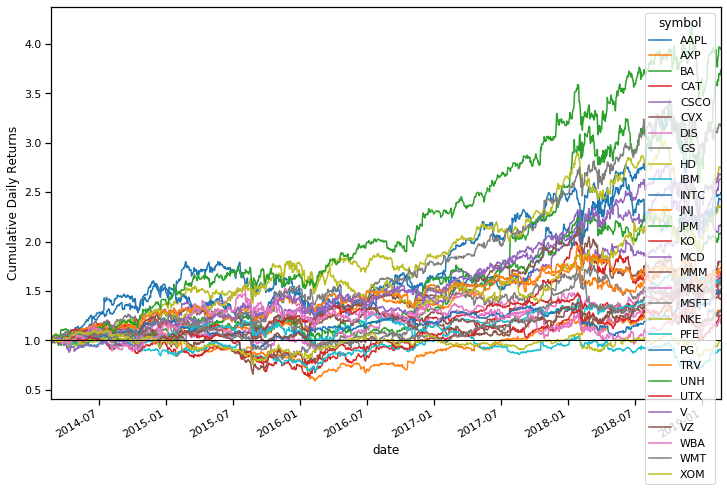

In [263]:
cum_daily_return = (1 + daily_pct_c).cumprod()

cum_daily_return.plot(figsize=(12,8))
plt.ylabel('Cumulative Daily Returns');
plt.axhline(1, color='black', lw=1)
plt.show()

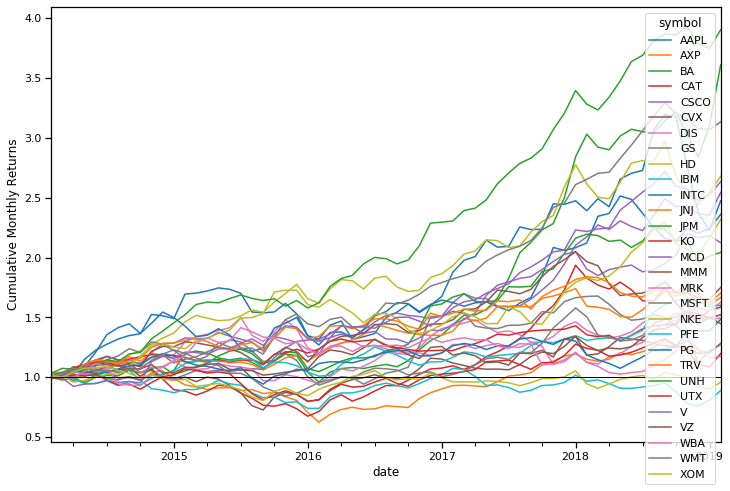

In [264]:
# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()

cum_monthly_return.plot(figsize=(12,8))
plt.ylabel('Cumulative Monthly Returns');
plt.axhline(1, color='black', lw=1)
plt.show()

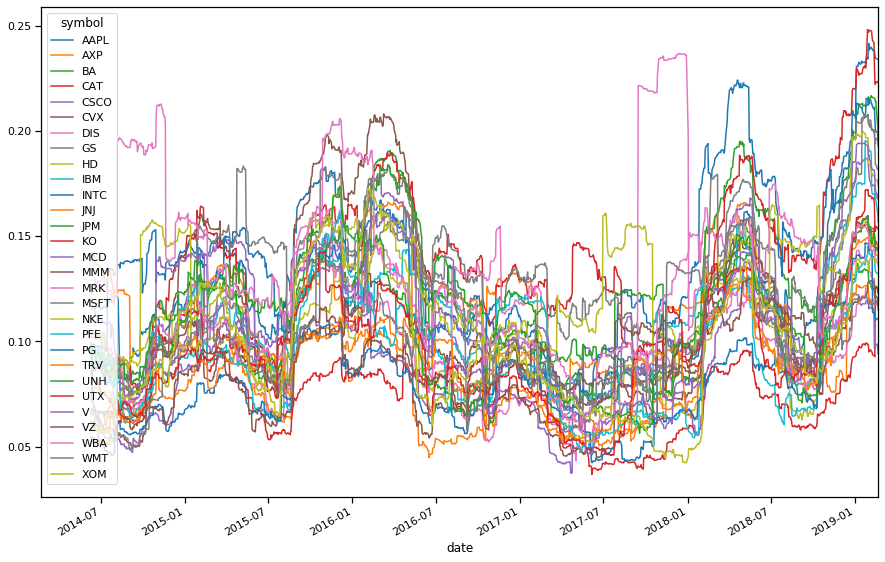

In [266]:
# Define the minumum of periods to consider 
min_periods = 75 

# Calculate the volatility
vol = daily_pct_c.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(15, 10))

# Show the plot
plt.show()

## Modeling Pipeline

In [267]:
#creating a separate dataset
AAPL_copy = pd.DataFrame(columns=['close'])
AAPL_copy.close = AAPL.close

AAPL_copy = AAPL_copy.reset_index()

AAPL_copy.head()

,date,close
0,2014-02-21,68.9821
1,2014-02-24,69.2841
2,2014-02-25,68.5631
3,2014-02-26,67.9446
4,2014-02-27,69.2999


In [268]:
AAPL_prophet = AAPL_copy.copy()
AAPL_prophet.head()

,date,close
0,2014-02-21,68.9821
1,2014-02-24,69.2841
2,2014-02-25,68.5631
3,2014-02-26,67.9446
4,2014-02-27,69.2999


In [205]:
#create features
add_datepart(AAPL_copy, 'date')
#AAPL_copy.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
AAPL_copy.head()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,68.9821,2014,2,8,21,4,52,False,False,False,False,False,False,1392940800
1,69.2841,2014,2,9,24,0,55,False,False,False,False,False,False,1393200000
2,68.5631,2014,2,9,25,1,56,False,False,False,False,False,False,1393286400
3,67.9446,2014,2,9,26,2,57,False,False,False,False,False,False,1393372800
4,69.2999,2014,2,9,27,3,58,False,False,False,False,False,False,1393459200


In [206]:
AAPL_copy['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (AAPL_copy['Dayofweek'][i] == 0 or AAPL_copy['Dayofweek'][i] == 4):
        AAPL_copy['mon_fri'][i] = 1
    else:
        AAPL_copy['mon_fri'][i] = 0

In [207]:
AAPL_copy.head()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,mon_fri
0,68.9821,2014,2,8,21,4,52,False,False,False,False,False,False,1392940800,1
1,69.2841,2014,2,9,24,0,55,False,False,False,False,False,False,1393200000,1
2,68.5631,2014,2,9,25,1,56,False,False,False,False,False,False,1393286400,0
3,67.9446,2014,2,9,26,2,57,False,False,False,False,False,False,1393372800,0
4,69.2999,2014,2,9,27,3,58,False,False,False,False,False,False,1393459200,0


In [208]:
AAPL_copy['sma5'] = AAPL_copy['close'].rolling(5).mean()
AAPL_copy['sma30'] = AAPL_copy['close'].rolling(30).mean()
 
AAPL_copy.tail()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,mon_fri,sma5,sma30
1253,170.18,2019,2,7,13,2,44,False,False,False,False,False,False,1550016000,0,170.22398,158.601393
1254,170.80,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400,0,170.34200,159.053210
1255,170.42,2019,2,7,15,4,46,False,False,False,False,False,False,1550188800,1,170.34400,160.014453
1256,170.93,2019,2,8,19,1,50,False,False,False,False,False,False,1550534400,0,170.64400,160.791227
1257,172.03,2019,2,8,20,2,51,False,False,False,False,False,False,1550620800,0,170.87200,161.615620


In [209]:
drop_cols = ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
AAPL_copy = AAPL_copy.drop(drop_cols, axis=1)
AAPL_copy.tail()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,mon_fri,sma5,sma30
1253,170.18,2019,2,7,13,2,44,1550016000,0,170.22398,158.601393
1254,170.80,2019,2,7,14,3,45,1550102400,0,170.34200,159.053210
1255,170.42,2019,2,7,15,4,46,1550188800,1,170.34400,160.014453
1256,170.93,2019,2,8,19,1,50,1550534400,0,170.64400,160.791227
1257,172.03,2019,2,8,20,2,51,1550620800,0,170.87200,161.615620


In [210]:
AAPL_copy.tail()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,mon_fri,sma5,sma30
1253,170.18,2019,2,7,13,2,44,1550016000,0,170.22398,158.601393
1254,170.80,2019,2,7,14,3,45,1550102400,0,170.34200,159.053210
1255,170.42,2019,2,7,15,4,46,1550188800,1,170.34400,160.014453
1256,170.93,2019,2,8,19,1,50,1550534400,0,170.64400,160.791227
1257,172.03,2019,2,8,20,2,51,1550620800,0,170.87200,161.615620


In [211]:
AAPL_copy = AAPL_copy.fillna(0)
AAPL_copy.head()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,mon_fri,sma5,sma30
0,68.9821,2014,2,8,21,4,52,1392940800,1,0.00000,0.0
1,69.2841,2014,2,9,24,0,55,1393200000,1,0.00000,0.0
2,68.5631,2014,2,9,25,1,56,1393286400,0,0.00000,0.0
3,67.9446,2014,2,9,26,2,57,1393372800,0,0.00000,0.0
4,69.2999,2014,2,9,27,3,58,1393459200,0,68.81476,0.0


In [212]:
AAPL_copy.dtypes

close        float64
Year           int64
Month          int64
Week           int64
Day            int64
Dayofweek      int64
Dayofyear      int64
Elapsed        int64
mon_fri        int64
sma5         float64
sma30        float64
dtype: object

In [213]:
AAPL_copy['Year'] = AAPL_copy['Year'].astype('object')
AAPL_copy['Month'] = AAPL_copy['Month'].astype('object')
AAPL_copy['Week'] = AAPL_copy['Week'].astype('object')
AAPL_copy['Day'] = AAPL_copy['Day'].astype('object')
AAPL_copy['Dayofweek'] = AAPL_copy['Dayofweek'].astype('object')
AAPL_copy['Dayofyear'] = AAPL_copy['Dayofyear'].astype('object')
AAPL_copy.dtypes

close        float64
Year          object
Month         object
Week          object
Day           object
Dayofweek     object
Dayofyear     object
Elapsed        int64
mon_fri        int64
sma5         float64
sma30        float64
dtype: object

In [214]:
pd.get_dummies(AAPL_copy['Year'])

,2014,2015,2016,2017,2018,2019
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
1253,0,0,0,0,0,1
1254,0,0,0,0,0,1
1255,0,0,0,0,0,1
1256,0,0,0,0,0,1


In [215]:
for column in AAPL_copy.columns:
    if AAPL_copy[column].dtype==object:
        dummyCols=pd.get_dummies(AAPL_copy[column])
        AAPL_copy=AAPL_copy.merge(dummyCols, left_index=True, right_index=True)
        del AAPL_copy[column]

AAPL_copy.head()

,close,Elapsed,mon_fri,sma5,sma30,2014,2015,2016,2017,2018,...,355,356,357,358,360,361,362,363,364,365
0,68.9821,1392940800,1,0.00000,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,69.2841,1393200000,1,0.00000,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68.5631,1393286400,0,0.00000,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67.9446,1393372800,0,0.00000,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,69.2999,1393459200,0,68.81476,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Linear Regression

In [216]:
# splitting into train and validation
train = AAPL_copy[:1004]
test = AAPL_copy[1004:]

x_train = train.drop('close', axis=1)
y_train = train['close']
x_test = test.drop('close', axis=1)
y_test = test['close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

#make predictions and find the rmse
preds = model.predict(x_test)
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

185.31494935889103

In [217]:
#plot
test['Predictions'] = 0
test['Predictions'] = preds

train.index = AAPL_copy[:1004].index
test.index = AAPL_copy[1004:].index

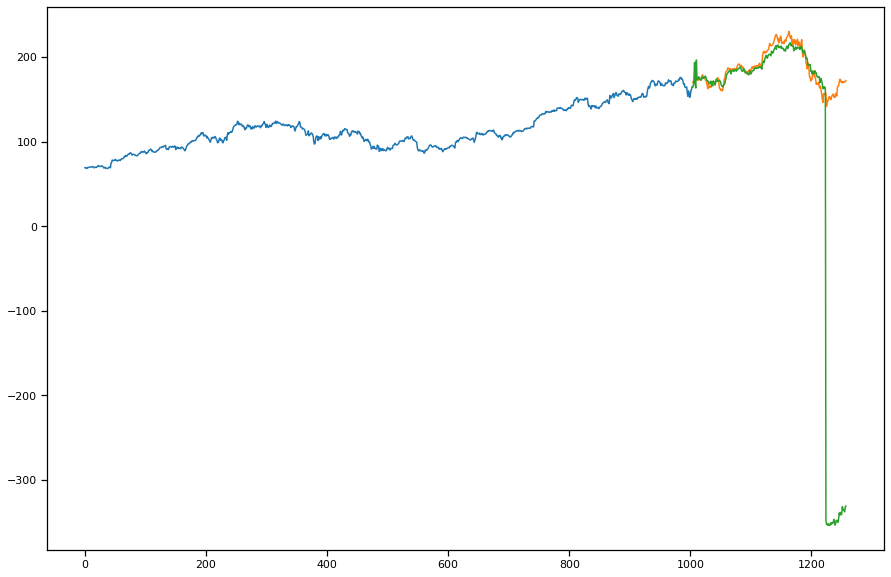

In [218]:
plt.figure(figsize=(15,10))
plt.plot(train['close'])
plt.plot(test[['close', 'Predictions']])

### K-Nearest Neighbors

In [219]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [220]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_test)

In [221]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

75.87751836938037

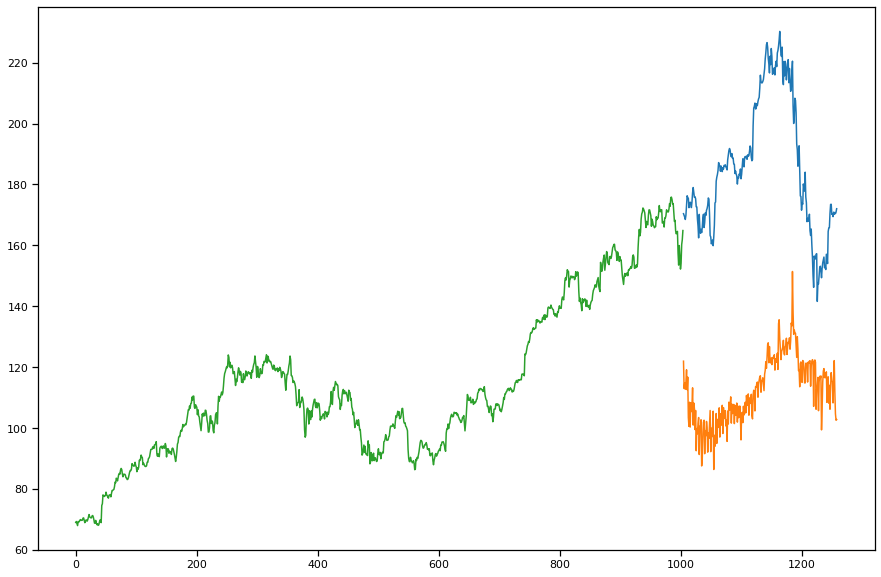

In [224]:
#plot
test['predictions'] = 0
test['predictions'] = preds

plt.figure(figsize=(15,10))
plt.plot(test[['close', 'predictions']])
plt.plot(train['close'])

### Auto Arima

In [228]:
from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = AAPL_copy[:1004]
test = AAPL_copy[1004:]

training = train['close']
testing = test['close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=254)
forecast = pd.DataFrame(forecast,index = test.index,columns=['prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3823.971, BIC=3848.464, Fit time=8.758 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4471.446, BIC=4481.244, Fit time=0.136 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4161.964, BIC=4181.559, Fit time=1.920 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3824.497, BIC=3844.092, Fit time=7.978 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3824.546, BIC=3853.938, Fit time=9.912 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4473.351, BIC=4492.946, Fit time=1.139 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3824.622, BIC=3854.014, Fit time=26.713 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3822.954, BIC=3857.245, Fit time=40.134 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3823.249, BIC=3852.641, Fit time=29.062 seconds
Fit ARIMA: order=(2, 1, 1

In [229]:
rms=np.sqrt(np.mean(np.power((np.array(test['close'])-np.array(forecast['prediction'])),2)))
rms

24.332372205614032

### Prophet

In [272]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])

for i in range(0,len(data)):
    new_data['date'][i] = AAPL_prophet['date'][i]
    new_data['close'][i] = AAPL_prophet['close'][i]

new_data['date'] = pd.to_datetime(new_data.date,format='%Y-%m-%d')
new_data.index = new_data['date']

#preparing data
new_data.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

#train and validation
train = new_data[:1004]
test = new_data[1004:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(test))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [273]:
#rmse
forecast_test = forecast['yhat'][1004:]
rms=np.sqrt(np.mean(np.power((np.array(test['y'])-np.array(forecast_test)),2)))
rms

23.785422111775933

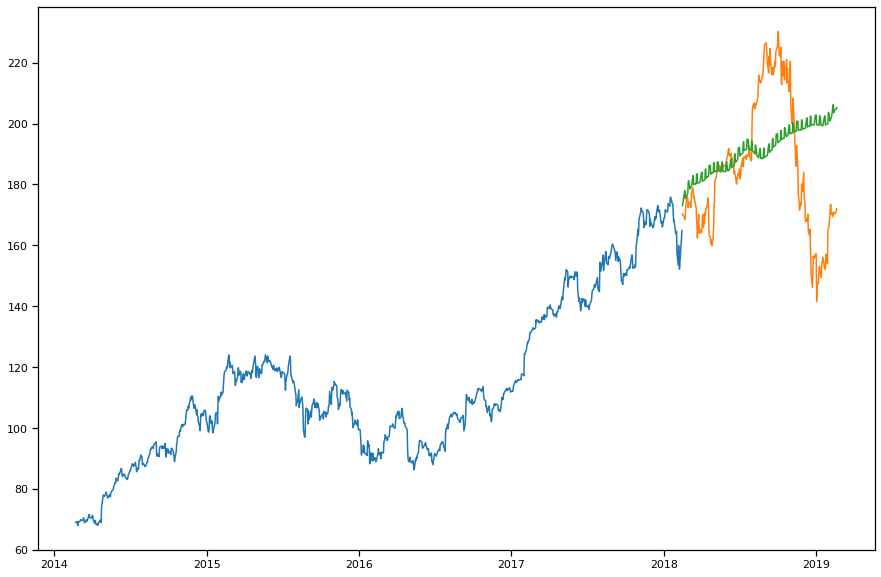

In [275]:
#plot
test['predictions'] = 0
test['predictions'] = forecast_test.values

plt.figure(figsize=(15,10))
plt.plot(train['y'])
plt.plot(test[['y', 'predictions']])

In [276]:
MSFT = pd.read_csv('stock-data-dow-jones/MSFT.csv', sep=',', index_col=0, parse_dates=True)
cols = ['open', 'high', 'low', 'close', 'volume']
MSFT = MSFT[cols].copy()

In [277]:
#creating a separate dataset
MSFT_copy = pd.DataFrame(columns=['close'])
MSFT_copy.close = MSFT.close

MSFT_copy = MSFT_copy.reset_index()

MSFT_copy.head()

,date,close
0,2014-02-21,33.7870
1,2014-02-24,33.5290
2,2014-02-25,33.3956
3,2014-02-26,33.3333
4,2014-02-27,33.6803


In [278]:
MSFT_prophet = MSFT_copy.copy()
MSFT_prophet.head()

,date,close
0,2014-02-21,33.7870
1,2014-02-24,33.5290
2,2014-02-25,33.3956
3,2014-02-26,33.3333
4,2014-02-27,33.6803


In [279]:
#create features
add_datepart(MSFT_copy, 'date')
#AAPL_copy.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
MSFT_copy.head()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,33.7870,2014,2,8,21,4,52,False,False,False,False,False,False,1392940800
1,33.5290,2014,2,9,24,0,55,False,False,False,False,False,False,1393200000
2,33.3956,2014,2,9,25,1,56,False,False,False,False,False,False,1393286400
3,33.3333,2014,2,9,26,2,57,False,False,False,False,False,False,1393372800
4,33.6803,2014,2,9,27,3,58,False,False,False,False,False,False,1393459200


In [280]:
MSFT_copy['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (MSFT_copy['Dayofweek'][i] == 0 or MSFT_copy['Dayofweek'][i] == 4):
        MSFT_copy['mon_fri'][i] = 1
    else:
        MSFT_copy['mon_fri'][i] = 0

In [281]:
MSFT_copy.head()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,mon_fri
0,33.7870,2014,2,8,21,4,52,False,False,False,False,False,False,1392940800,1
1,33.5290,2014,2,9,24,0,55,False,False,False,False,False,False,1393200000,1
2,33.3956,2014,2,9,25,1,56,False,False,False,False,False,False,1393286400,0
3,33.3333,2014,2,9,26,2,57,False,False,False,False,False,False,1393372800,0
4,33.6803,2014,2,9,27,3,58,False,False,False,False,False,False,1393459200,0


In [282]:
MSFT_copy['sma5'] = MSFT_copy['close'].rolling(5).mean()
MSFT_copy['sma30'] = MSFT_copy['close'].rolling(30).mean()
 
MSFT_copy.tail()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,mon_fri,sma5,sma30
1253,106.3557,2019,2,7,13,2,44,False,False,False,False,False,False,1550016000,0,105.52728,104.171737
1254,106.4454,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400,0,105.85190,104.363587
1255,107.7597,2019,2,7,15,4,46,False,False,False,False,False,False,1550188800,1,106.35972,104.722717
1256,107.7100,2019,2,8,19,1,50,False,False,False,False,False,False,1550534400,0,106.94124,104.929833
1257,107.1500,2019,2,8,20,2,51,False,False,False,False,False,False,1550620800,0,107.08416,105.113970


In [283]:
drop_cols = ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
MSFT_copy = MSFT_copy.drop(drop_cols, axis=1)
MSFT_copy.tail()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,mon_fri,sma5,sma30
1253,106.3557,2019,2,7,13,2,44,1550016000,0,105.52728,104.171737
1254,106.4454,2019,2,7,14,3,45,1550102400,0,105.85190,104.363587
1255,107.7597,2019,2,7,15,4,46,1550188800,1,106.35972,104.722717
1256,107.7100,2019,2,8,19,1,50,1550534400,0,106.94124,104.929833
1257,107.1500,2019,2,8,20,2,51,1550620800,0,107.08416,105.113970


In [284]:
MSFT_copy.tail()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,mon_fri,sma5,sma30
1253,106.3557,2019,2,7,13,2,44,1550016000,0,105.52728,104.171737
1254,106.4454,2019,2,7,14,3,45,1550102400,0,105.85190,104.363587
1255,107.7597,2019,2,7,15,4,46,1550188800,1,106.35972,104.722717
1256,107.7100,2019,2,8,19,1,50,1550534400,0,106.94124,104.929833
1257,107.1500,2019,2,8,20,2,51,1550620800,0,107.08416,105.113970


In [285]:
MSFT_copy = MSFT_copy.fillna(0)
MSFT_copy.head()

,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,mon_fri,sma5,sma30
0,33.7870,2014,2,8,21,4,52,1392940800,1,0.00000,0.0
1,33.5290,2014,2,9,24,0,55,1393200000,1,0.00000,0.0
2,33.3956,2014,2,9,25,1,56,1393286400,0,0.00000,0.0
3,33.3333,2014,2,9,26,2,57,1393372800,0,0.00000,0.0
4,33.6803,2014,2,9,27,3,58,1393459200,0,33.54504,0.0


In [286]:
MSFT_copy.dtypes

close        float64
Year           int64
Month          int64
Week           int64
Day            int64
Dayofweek      int64
Dayofyear      int64
Elapsed        int64
mon_fri        int64
sma5         float64
sma30        float64
dtype: object

In [287]:
MSFT_copy['Year'] = MSFT_copy['Year'].astype('object')
MSFT_copy['Month'] = MSFT_copy['Month'].astype('object')
MSFT_copy['Week'] = MSFT_copy['Week'].astype('object')
MSFT_copy['Day'] = MSFT_copy['Day'].astype('object')
MSFT_copy['Dayofweek'] = MSFT_copy['Dayofweek'].astype('object')
MSFT_copy['Dayofyear'] = MSFT_copy['Dayofyear'].astype('object')
MSFT_copy.dtypes

close        float64
Year          object
Month         object
Week          object
Day           object
Dayofweek     object
Dayofyear     object
Elapsed        int64
mon_fri        int64
sma5         float64
sma30        float64
dtype: object

In [288]:
pd.get_dummies(MSFT_copy['Year'])

,2014,2015,2016,2017,2018,2019
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
1253,0,0,0,0,0,1
1254,0,0,0,0,0,1
1255,0,0,0,0,0,1
1256,0,0,0,0,0,1


In [289]:
for column in MSFT_copy.columns:
    if MSFT_copy[column].dtype==object:
        dummyCols=pd.get_dummies(MSFT_copy[column])
        MSFT_copy=MSFT_copy.merge(dummyCols, left_index=True, right_index=True)
        del MSFT_copy[column]

MSFT_copy.head()

,date,close
0,2014-02-21,68.9821
1,2014-02-24,69.2841
2,2014-02-25,68.5631
3,2014-02-26,67.9446
4,2014-02-27,69.2999


In [290]:
# splitting into train and validation
train = MSFT_copy[:1004]
test = MSFT_copy[1004:]

x_train = train.drop('close', axis=1)
y_train = train['close']
x_test = test.drop('close', axis=1)
y_test = test['close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

#make predictions and find the rmse
preds = model.predict(x_test)
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

217.06779503999127

### Linear Regression

In [291]:
#plot
test['Predictions'] = 0
test['Predictions'] = preds

train.index = MSFT_copy[:1004].index
test.index = MSFT_copy[1004:].index

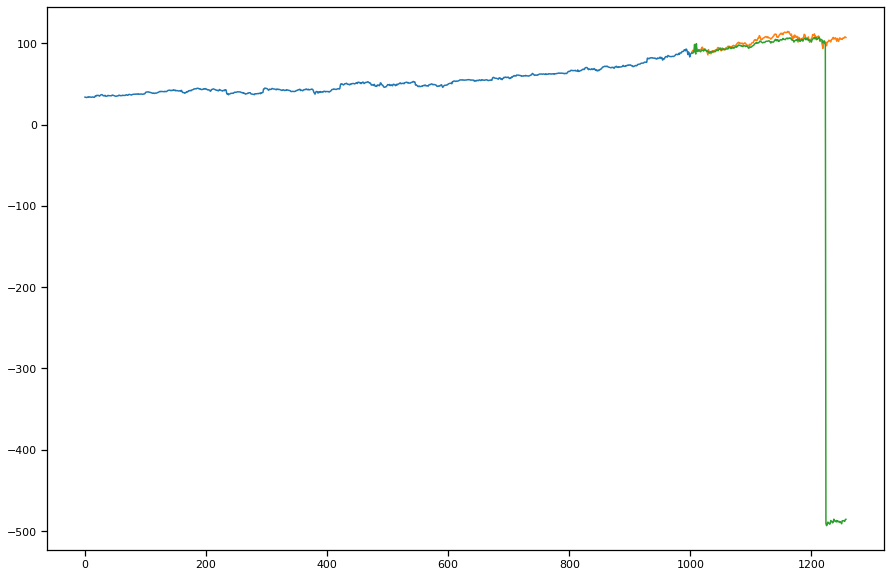

In [292]:
plt.figure(figsize=(15,10))
plt.plot(train['close'])
plt.plot(test[['close', 'Predictions']])

### K-Nearest Neighbors

In [293]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [294]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_test)

In [295]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

134.2308946445214

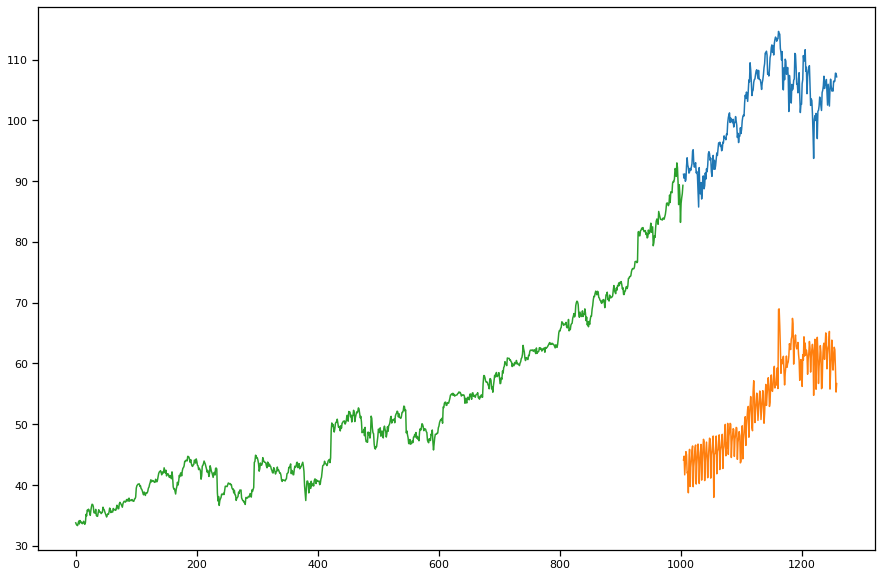

In [296]:
#plot
test['predictions'] = 0
test['predictions'] = preds

plt.figure(figsize=(15,10))
plt.plot(test[['close', 'predictions']])
plt.plot(train['close'])

### Auto Arima

In [297]:
from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = MSFT_copy[:1004]
test = MSFT_copy[1004:]

training = train['close']
testing = test['close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=254)
forecast = pd.DataFrame(forecast,index = test.index,columns=['prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2211.582, BIC=2236.076, Fit time=14.312 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2821.466, BIC=2831.264, Fit time=0.130 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2550.171, BIC=2569.766, Fit time=2.478 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2216.501, BIC=2236.095, Fit time=5.489 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2213.107, BIC=2242.500, Fit time=15.606 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2820.372, BIC=2839.967, Fit time=1.240 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2216.086, BIC=2245.478, Fit time=34.106 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2218.382, BIC=2252.673, Fit time=49.718 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2215.398, BIC=2244.791, Fit time=15.898 seconds
Fit ARIMA: order=(1, 1,

In [298]:
rms=np.sqrt(np.mean(np.power((np.array(test['close'])-np.array(forecast['prediction'])),2)))
rms

7.045846717555236

### Prophet

In [299]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])

for i in range(0,len(data)):
    new_data['date'][i] = MSFT_prophet['date'][i]
    new_data['close'][i] = MSFT_prophet['close'][i]

new_data['date'] = pd.to_datetime(new_data.date,format='%Y-%m-%d')
new_data.index = new_data['date']

#preparing data
new_data.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

#train and validation
train = new_data[:1004]
test = new_data[1004:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(test))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [300]:
#rmse
forecast_test = forecast['yhat'][1004:]
rms=np.sqrt(np.mean(np.power((np.array(test['y'])-np.array(forecast_test)),2)))
rms

6.801622220671381

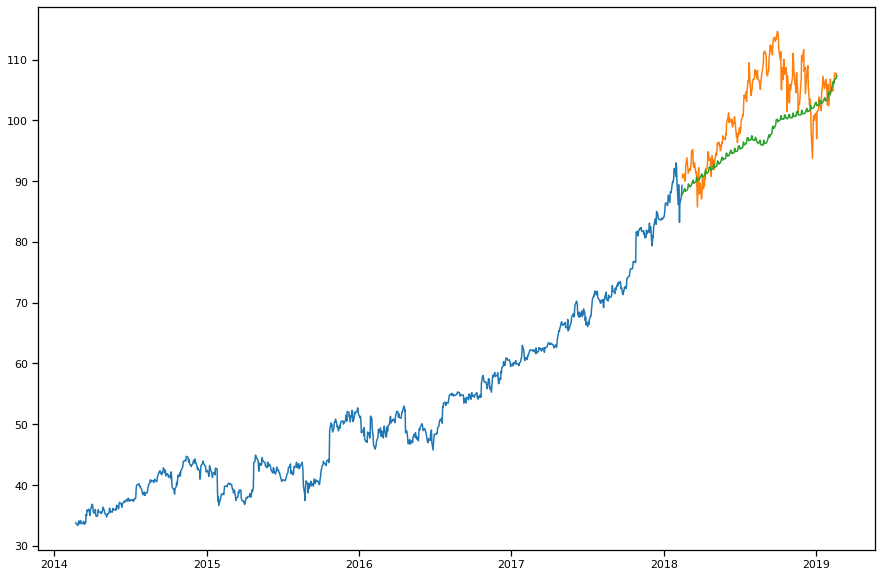

In [301]:
#plot
test['predictions'] = 0
test['predictions'] = forecast_test.values

plt.figure(figsize=(15,10))
plt.plot(train['y'])
plt.plot(test[['y', 'predictions']])

## Conclusion

Out of the four models we tried, the best performing one was Prophet, with Auto Arima being a close second.